# Import Packages

This is a PyJAGS implementation of Joel Hasbrouck's Bayesian Gibbs estimator of Roll's bid-ask bounce model developed in the 2009 Journal of Finance paper 'Trading Costs and Returns for U.S. Equities: Estimating Effective Costs from Daily Data'. 

The published version of the paper is available from Wiley at https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1540-6261.2009.01469.x and from JSTOR at https://www.jstor.org/stable/20488006?seq=1. 

A working paper version can be found on SSRN at https://papers.ssrn.com/sol3/papers.cfm?abstract_id=388360.

The example presented here estimates trading costs for the Ford Motor company during 2018 and uses the S&P 500 as a market proxy.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import os
import typing as tp

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyjags
import seaborn as sns
sns.set(color_codes=True)

In [4]:
figsize = (12,8)
plt.rcParams["figure.figsize"] = figsize

# Read Data

In [5]:
spy_filename = os.path.join('data', 'SPY.csv')
ford_filename = os.path.join('data', 'F.csv')

In [6]:
def read_yahoo_log_return_df(filepath: str,
                             dropna: bool=True) -> pd.DataFrame:
    df = pd.read_csv(filepath)

    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df['Log Return'] = np.log(df['Adj Close']).diff().dropna()

    if dropna:
        df = df.dropna().copy()

    return df

In [7]:
log_return_df = read_yahoo_log_return_df(ford_filename, dropna=False)

In [8]:
spy_log_return_df = read_yahoo_log_return_df(spy_filename, dropna=False)
spy_log_return_df = \
    (spy_log_return_df
     .loc[:, ['Date', 'Log Return']]
     .rename(columns={'Log Return': 'Market Log Return'})
     .copy())
spy_log_return_df.head()

,Date,Market Log Return
0,1993-01-29,NaN
1,1993-02-01,0.007087
2,1993-02-02,0.002117
3,1993-02-03,0.010514
4,1993-02-04,0.004176


In [9]:
merged_df = \
    pd.merge(left=log_return_df, 
             right=spy_log_return_df, 
             on='Date')
merged_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Log Return,Market Log Return
0,1993-01-29,8.530765,8.530765,8.325479,8.416717,3.441026,6689089,-0.010782,NaN
1,1993-02-01,8.462337,8.622003,8.302670,8.622003,3.524955,5085045,0.024098,0.007087
2,1993-02-02,8.622003,8.667622,8.530765,8.599194,3.515630,7758270,-0.002649,0.002117
3,1993-02-03,8.576384,8.736051,8.553575,8.713241,3.562257,10190915,0.013176,0.010514
4,1993-02-04,8.895718,9.169432,8.850099,9.146623,3.739438,26850068,0.048541,0.004176


In [10]:
log_return_df = None
spy_log_return_df = None

In [11]:
merged_df = merged_df.loc[merged_df['Date'].between('2018-01-01', '2018-12-31'), :].copy()
log_returns = merged_df['Log Return'].values
log_price = np.log(merged_df['Adj Close'].values)
datetime = merged_df['Date'].values
volume = merged_df['Volume'].values
market_log_return = merged_df['Market Log Return']

In [12]:
N = len(log_price)
assert N == len(volume)
N

251

# Roll's Bid-Ask Bounce Model

The efficient (midpoint) price $m$ evolves according to  

$m_t = m_{t-1} + u_t$  $u \sim N \left( 0, \sigma_u^2 \right)$ i.i.d  

The observed price $p$ is given by  

$p_t = m_t + c q_t$,

where $c$ denotes the cost of trading and $q_t \in \{ +1, 0, -1\}$ is an aggressor flag that is $+1$ if the trade is buyer initiated, $-1$ if it is seller initiated, or $0$ if no trade occurred over the reporting period and the reported price is at the midpoint.

Differentiating $p_t$ and using the definition of $m_t$, one obtains  

$\Delta p_t = p_t - p_{t-1} = c \Delta q_t + u_t$

We use the following priors:  
$
\begin{align*}
c & \sim N^+ \left( 0, 0.05^2 \right) \\
\sigma_u^2 & \sim \text{Inv-Gamma} \left( 10^{-12}, 10^{-12}\right) \\
q_t & \sim \text{Bernoulli} \left( \frac{1}{2} \right),
\end{align*}
$  
where $N^+$ denotes a normal distribution truncated below at zero. 

## JAGS Model Construction

In [13]:
prior_sigma_c = 0.05
prior_a = 1e-12
prior_b = 1e-12

In [14]:
def construct_hasbrouck_model(log_price: np.ndarray, 
                              volume: np.ndarray, 
                              prior_sigma_c: float, 
                              prior_a: float, 
                              prior_b: float, 
                              chains: int = 4, 
                              threads: tp.Optional[int] = None) -> pyjags.Model:
    if not threads:
        threads = chains
        
    hasbrouck_jags_model_string = '''
    model {
        for (t in 1:length(volume)) {        
            o[t] = ifelse(volume[t] == 0.0, 0, 1)
            l[t] ~ dbern(0.5)  # {0, 1}
            # Map random variable onto {-1, 1} and set to zero if trading volume equals zero
            q[t] = o[t] * (2.0 * l[t] - 1.0)
        }

        for (t in 2:length(volume)) {
            p[t] ~ dnorm(p[t-1] + c * (q[t] - q[t-1]), tau)
        }
        c ~ dnorm(0.0, prior_sigma_c^(-2)) I(0, )
        tau ~ dgamma(prior_a, prior_b)
        sigma = 1.0/sqrt(tau)
    }
    '''
    
    jags_data = {
        'p': log_price, 
        'volume': volume, 
        'prior_sigma_c': prior_sigma_c, 
        'prior_a': prior_a, 
        'prior_b': prior_b, 
    }
    
    return pyjags.Model(code=hasbrouck_jags_model_string, 
                        data=jags_data, 
                        chains=chains, 
                        threads=threads)

In [15]:
jags_model = \
    construct_hasbrouck_model(
        log_price=log_price, 
        volume=volume, 
        prior_sigma_c=prior_sigma_c, 
        prior_a=prior_a, 
        prior_b=prior_b
)

## Gibbs Sampling

Separate stochastic nodes into scalar parameters and state variables. 

In [16]:
parameter_names = ['c', 'sigma']
state_variable_names = ['q']
variables = parameter_names + state_variable_names

Sample from JAGS model, discarding the first 1000 iterations as burn-in and keeping the next 2000 iterations for each chain.

In [17]:
jags_model.sample(1000, vars=[])

samples \
    = jags_model.sample(iterations=2000, vars=variables)

sampling: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 8000 of 8000, elapsed 0:00:00, remaining 0:00:00


Compute posterior mean of $c$

In [18]:
samples['c'].flatten().mean()

0.00219108588692976

Convert JAGS output into an Arviz object for visualization and convergence analysis

In [19]:
idata = az.from_pyjags(samples)

## Model Diagnostics

### Trace Plot

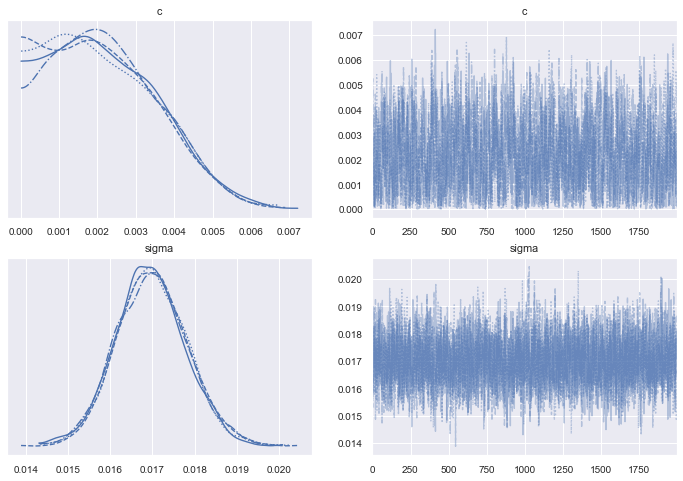

In [20]:
az.plot_trace(idata, 
              var_names=parameter_names, 
              figsize=figsize);

### Gelman-Rubin $\hat{R}$ Statistic

In [21]:
az.rhat(idata, var_names=parameter_names)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    c        float64 1.003
    sigma    float64 1.001

The Gelman-Rubin $\hat{R}$ statistic is close to $1$ indicating the within chain variance and between-chain variance are close to each other. If those were to diverge significantly (say by more than $10$ percent, it would would be a red flag and indicate non-convergence of the Markov Chain simulation.

### Effective Sample Size

In [22]:
az.ess(idata, var_names=parameter_names)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    c        float64 1.158e+03
    sigma    float64 3.317e+03

## Posterior

### Parameters

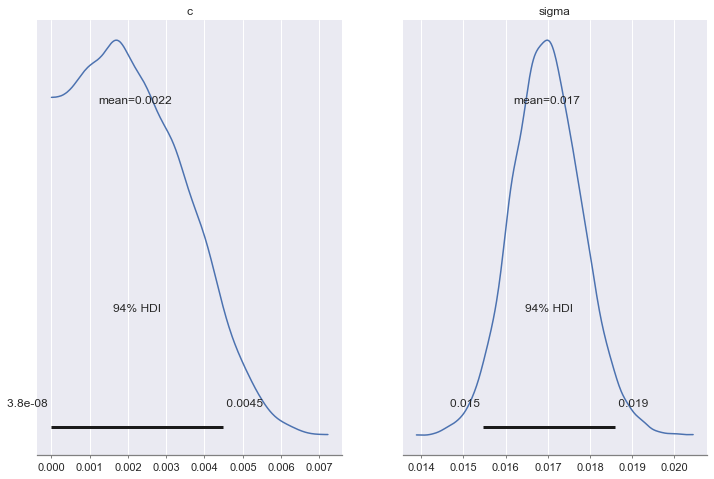

In [23]:
az.plot_posterior(idata, 
                  var_names=parameter_names, 
                  figsize=figsize);

### Posterior Mean of Trade Direction

In [24]:
def plot_posterior_mean_of_trade_direction(arviz_data, datetime, aggregate_chains: bool = True):
    data = arviz_data.posterior['q']
    data = data.mean(axis=1).T
    if aggregate_chains:
        data = data.mean(axis=1)
        
    plt.plot(datetime, data, marker='.', linestyle='None');

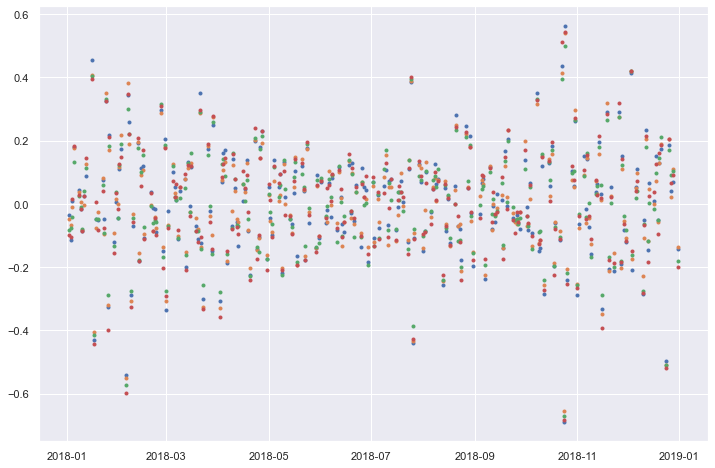

In [25]:
plot_posterior_mean_of_trade_direction(idata, datetime, aggregate_chains=False)

# Roll's Bid-Ask Bounce Model with Market Factor

The efficient (midpoint) price $m$ evolves according to  

$m_t = m_{t-1} + \beta_m r_{m, t} + u_t$  $u \sim N \left( 0, \sigma_u^2 \right)$ i.i.d  

The observed price $p$ is given by  

$p_t = m_t + c q_t$,

where $c$ denotes the cost of trading and $q_t \in \{ +1, 0, -1\}$ is an aggressor flag that is $+1$ if the trade is buyer initiated, $-1$ if it is seller initiated, or $0$ if no trade occurred over the reporting period and the reported price is at the midpoint.

Differentiating $p_t$ and using the definition of $m_t$, one obtains  

$\Delta p_t = p_t - p_{t-1} = c \Delta q_t + \beta_m r_{m, t} + u_t$.

The priors on $c$, $\{q_t\}$, and $\sigma_u^2$ are the same as in the case without a market factor discussed above. Additionally, the prior on $\beta_m$ is $N(1, 1)$.

In [26]:
prior_sigma_beta_m = 1.0

In [27]:
def construct_hasbrouck_model_with_market_factor(
        log_price: np.ndarray, 
        volume: np.ndarray, 
        market_log_return: np.ndarray, 
        prior_sigma_c: float, 
        prior_a: float, 
        prior_b: float) \
    -> pyjags.Model:
    hasbrouck_jags_model_string_with_market_factor = '''
    model {
        for (t in 1:length(volume)) {        
            o[t] = ifelse(volume[t] == 0.0, 0, 1)
            l[t] ~ dbern(0.5)  # {0, 1}
            # Map random variable onto {-1, 1} and set to zero if trading volume equals zero
            q[t] = o[t] * (2.0 * l[t] - 1.0)
        }

        for (t in 2:length(volume)) {
            p[t] ~ dnorm(p[t-1] + c * (q[t] - q[t-1]) + beta_m * market_log_return[t], tau)
        }
        beta_m ~ dnorm(1.0, prior_sigma_beta_m^(-2))
        c ~ dnorm(0.0, prior_sigma_c^(-2)) I(0, )
        tau ~ dgamma(prior_a, prior_b)
        sigma = 1.0/sqrt(tau)
    }
    '''
    
    jags_data_with_market_factor = {
        'p': log_price, 
        'volume': volume, 
        'market_log_return': market_log_return, 
        'prior_sigma_c': prior_sigma_c, 
        'prior_a': prior_a, 
        'prior_b': prior_b, 
        'prior_sigma_beta_m': prior_sigma_beta_m
    }
    
    return pyjags.Model(code=hasbrouck_jags_model_string_with_market_factor, 
                        data=jags_data_with_market_factor, 
                        chains=4, 
                        threads=4)

In [28]:
jags_model_with_market_factor = \
    construct_hasbrouck_model_with_market_factor(
        log_price=log_price, 
        volume=volume, 
        market_log_return=market_log_return, 
        prior_sigma_c=prior_sigma_c, 
        prior_a=prior_a, 
        prior_b=prior_b
)

Separate stochastic nodes into scalar parameters and state variables. 

In [29]:
parameter_names_with_market_factor = ['c', 'sigma', 'beta_m']
state_variable_names = ['q']
variables_with_market_factor = parameter_names_with_market_factor + state_variable_names

Sample from JAGS model, discarding the first 1000 iterations as burn-in and keeping the next 2000 iterations for each chain.

In [30]:
jags_model_with_market_factor.sample(1000, vars=[])

samples_with_market_factor \
    = jags_model_with_market_factor.sample(iterations=2000, 
                                           vars=variables_with_market_factor)

sampling: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 8000 of 8000, elapsed 0:00:00, remaining 0:00:00


Compute posterior mean of $c$

In [31]:
samples_with_market_factor['c'].flatten().mean()

0.001601289439860786

Compute posterior mean of $\beta_m$

In [32]:
samples_with_market_factor['beta_m'].flatten().mean()

0.8153824181442092

Convert JAGS output into an Arviz object for visualization and convergence analysis

In [33]:
idata_with_market_factor = az.from_pyjags(samples_with_market_factor)

## Model Diagnostics

### Trace Plot

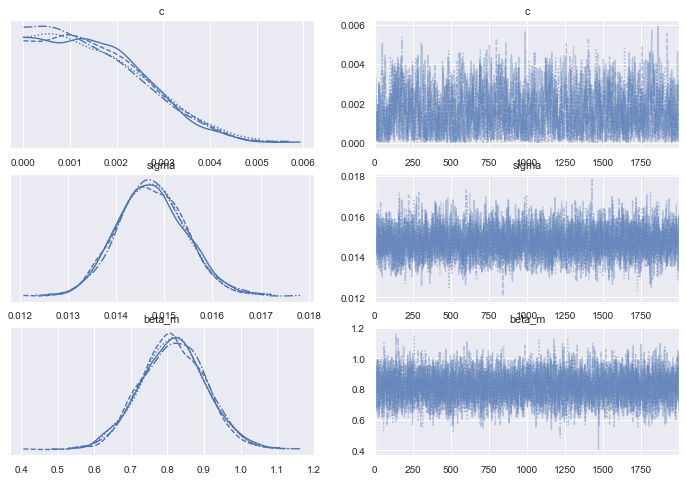

In [34]:
az.plot_trace(idata_with_market_factor, 
              var_names=parameter_names_with_market_factor, 
              figsize=figsize);

### Gelman-Rubin $\hat{R}$ Statistic

In [35]:
az.rhat(idata_with_market_factor, var_names=parameter_names_with_market_factor)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    c        float64 1.001
    sigma    float64 1.0
    beta_m   float64 1.0

### Effective Sample Size

In [36]:
az.ess(idata_with_market_factor, var_names=parameter_names_with_market_factor)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    c        float64 1.293e+03
    sigma    float64 4.37e+03
    beta_m   float64 7.358e+03

## Posterior

### Parameters

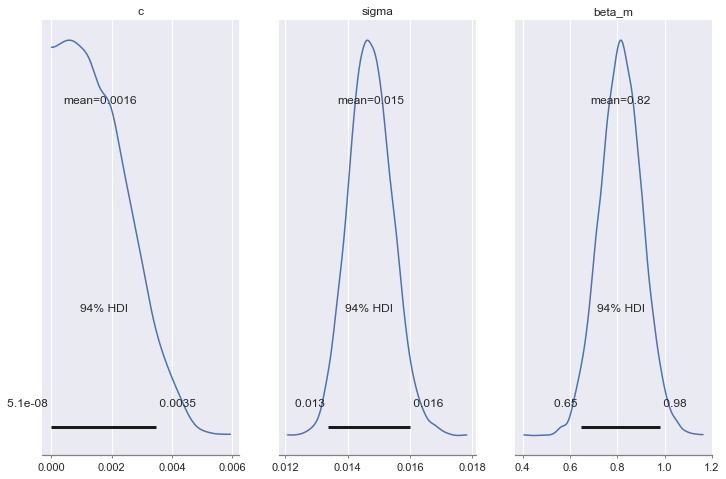

In [37]:
az.plot_posterior(idata_with_market_factor, 
                  var_names=parameter_names_with_market_factor, 
                  figsize=figsize);

### Posterior Mean of Trade Direction

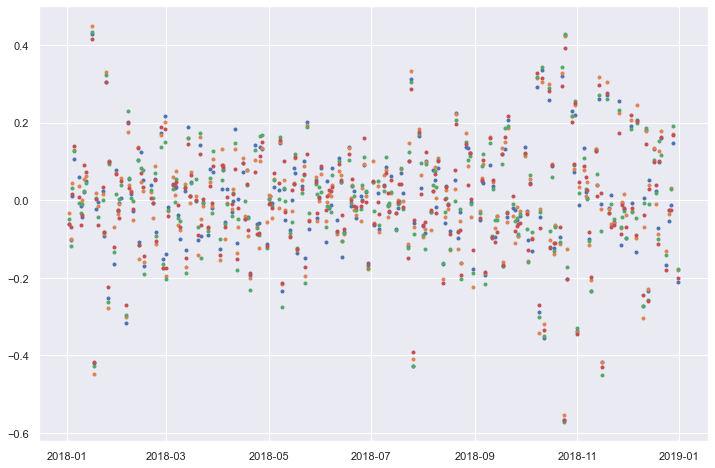

In [38]:
plot_posterior_mean_of_trade_direction(idata_with_market_factor, datetime, aggregate_chains=False)